In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [6]:
def convert_dataset(filename):
    """
    Convert values in scientific notation to normal decimal format in a dataset.
    
    Args:
    dataset (str): A string representing a dataset with values potentially in scientific notation.
    
    Returns:
    list: A list of lists of decimal values, where each inner list represents a row of data.
    """
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    decimal_dataset = []
    for line in lines:
        values = line.strip().split()
        decimal_values = []
        for value in values:
            if 'E' in value:  # Check if scientific notation is present
                base, exponent = value.split('E')
                decimal_value = float(base) * (10 ** int(exponent))
                decimal_values.append(decimal_value)
            else:
                decimal_values.append(float(value))
        decimal_dataset.append(decimal_values)
    
    return np.array(decimal_dataset)


In [7]:
data = convert_dataset('or_leakage2.txt')[:50000]
data = (data - data.mean(axis=0)) / data.std(axis=0)

In [8]:
print(data[0].shape)

(20,)


In [9]:

# Split data into features and labels
X = data[:, :-1]
y = data[:, -1]

# standardize the data
# X = (X - X.mean(axis=0)) / X.std(axis=0)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:


# Baseline models
lr_model = LinearRegression()
rf_model = RandomForestRegressor()
dt_model = DecisionTreeRegressor()
svr_model = SVR()


# Train baseline models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)
svr_model.fit(X_train, y_train)



SVR()

In [11]:
# print params 
print(lr_model.coef_)
# print(rf_model.coef_)
# print(dt_model.coef_)
# print(svr_model.coef_)



[ 3.74541981e-02  9.12132346e-03  3.25853993e-01  2.92682019e-01
  1.44353461e-03 -8.60005852e-02  6.92615698e-01 -1.16358052e-01
 -2.98881728e-01  2.31445224e-02  3.55726136e-02  1.13574008e-02
  1.83138925e-02 -5.06695662e-03  3.86447140e-04  2.38456352e-03
  3.39045097e-03  4.00281480e-03 -1.63881741e-03]


In [12]:
print("LR SCORE ",lr_model.score(X_test, y_test))
print("SVR SCORE ",svr_model.score(X_test, y_test))
print("RF SCORE ",rf_model.score(X_test, y_test))
print("DT SCORE ",dt_model.score(X_test, y_test))

LR SCORE  0.7809965357821326


SVR SCORE  0.9844333295578137
RF SCORE  0.9353547804660575
DT SCORE  0.8967889648047818


In [13]:
def make_plot(model, X, y):
    """
    Plot the model's predictions against the actual labels.
    
    Args:
    model: A trained regression model.
    X (ndarray): An array of shape (n_samples, n_features) representing the input data.
    y (ndarray): An array of shape (n_samples,) representing the target labels.
    """
    import matplotlib.pyplot as plt
    y_pred = model.predict(X)
    plt.scatter(y, y_pred)
    plt.xlabel('Actual Labels')
    plt.ylabel('Predicted Labels')
    plt.title('Actual vs Predicted Labels')
    plt.show()
    


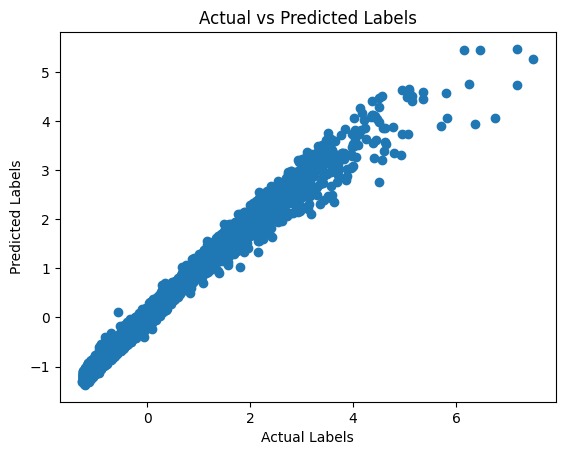

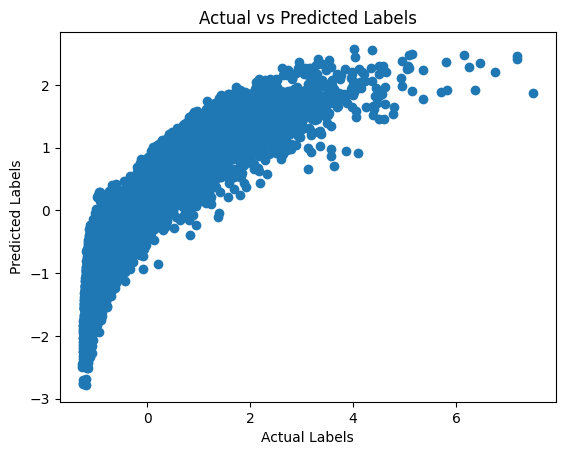

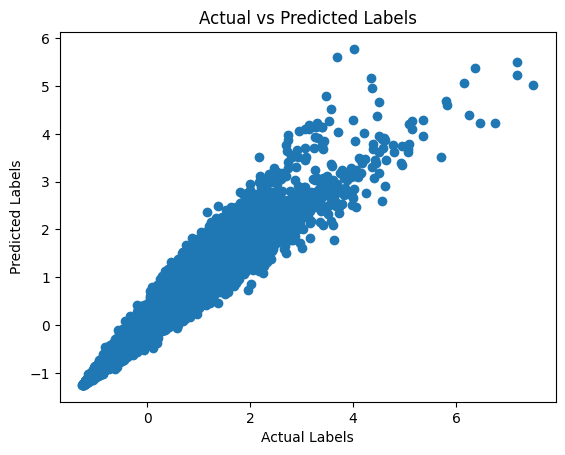

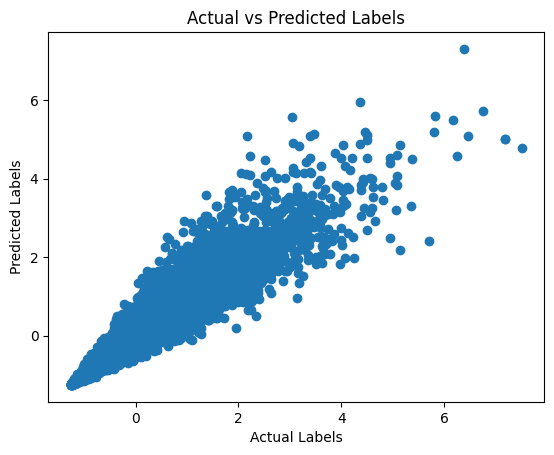

In [14]:
make_plot(svr_model, X_test, y_test)
make_plot(lr_model, X_test, y_test)
make_plot(rf_model, X_test, y_test)
make_plot(dt_model, X_test, y_test)

In [15]:

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # Max pooling layers
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 2, 128)  # 64 channels * 19 length vector
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)  # Output dimension of length 4
        
    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = F.relu(self.conv1(x.unsqueeze(1)))  # Add 1 channel dimension for 1D convolution
        x = self.pool(x)
        # print("dimenstion after conv1: ", x.shape)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # print("dimenstion after conv2: ", x.shape)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        # print("dimenstion after conv3: ", x.shape)
        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)  # Adjusted based on the output size after pooling
        # print(x.shape)
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # Final linear layer without softmax activation
        x = self.fc3(x) 
        #divide by max value in x from x
        x = x / torch.max(x)
        # add softmax
        x = F.softmax(x, dim=1)
        return x

# Initialize the model
model = CNN()
print(model)


CNN(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


In [16]:

def get_predictions(inputs):
    lr_pred = lr_model.predict(inputs)
    rf_pred = rf_model.predict(inputs)
    dt_pred = dt_model.predict(inputs)
    svr_pred = svr_model.predict(inputs)
    return rf_pred, dt_pred, svr_pred, lr_pred

# Define the model
model = CNN()

# Define the loss function (MSE loss)
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

def train_model(model, optimizer, criterion, inputs, targets,epochs=10, batch_size=64):
    model.train()
    loss_arr = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for i in range(0, len(inputs), batch_size):
            batch_inputs = inputs[i:i+batch_size]
            batch_targets = targets[i:i+batch_size]
            batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
            batch_targets = torch.tensor(batch_targets, dtype=torch.float32)
            batch_inputs = batch_inputs.clone().detach().to(torch.float32)
            batch_targets = batch_targets.clone().detach().to(torch.float32)
            optimizer.zero_grad()
            output = model(batch_inputs)
            rf_pred, dt_pred, svr_pred, lr_pred = get_predictions(batch_inputs)
            all_predictions = torch.tensor(np.vstack([rf_pred, dt_pred,svr_pred,lr_pred]), dtype=torch.float32)
            all_predictions = all_predictions.T
            # print(output, all_predictions, batch_targets)
            # print(all_predictions.shape, output.shape)
            pred = torch.sum(all_predictions*output, dim=1)
            # print(batch_targets)
            # print(pred.shape, batch_targets.shape)
            loss = criterion(pred, batch_targets)
            # print(pred, loss.item())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_inputs.size(0)
        epoch_loss /= len(inputs)
        print("Epoch:", epoch, "Loss:", epoch_loss)
        loss_arr.append(epoch_loss)
        
    return loss_arr

    

# Example usage:
inputs = torch.tensor(X_train, dtype=torch.float32)
targets = torch.tensor(y_train, dtype=torch.float32)

In [18]:
# Train the model for one iteration
loss_arr  = train_model(model, optimizer, criterion, inputs, targets,10,64)
# plot of loss vs epochs



/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_targets = torch.tensor(batch_targets, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is rec

Epoch: 0 Loss: 0.0168357047886891


/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_targets = torch.tensor(batch_targets, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is rec

Epoch: 1 Loss: 0.02311792496105875


/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_targets = torch.tensor(batch_targets, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is rec

Epoch: 2 Loss: 0.02939313007401809


/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_targets = torch.tensor(batch_targets, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is rec

Epoch: 3 Loss: 0.036528571728058276


/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_targets = torch.tensor(batch_targets, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is rec

Epoch: 4 Loss: 0.04623191953821231


/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_targets = torch.tensor(batch_targets, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is rec

Epoch: 5 Loss: 0.052833005046402697


/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_targets = torch.tensor(batch_targets, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is rec

Epoch: 6 Loss: 0.06133086691848357


/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_targets = torch.tensor(batch_targets, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is rec

Epoch: 7 Loss: 0.06745187441399066


/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_targets = torch.tensor(batch_targets, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is rec

Epoch: 8 Loss: 0.07120251894766849


/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_targets = torch.tensor(batch_targets, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is rec

Epoch: 9 Loss: 0.0783961781375558


/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_targets = torch.tensor(batch_targets, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_inputs = torch.tensor(batch_inputs, dtype=torch.float32)
/tmp/ipykernel_360148/3683083266.py:26: UserWarning: To copy construct from a tensor, it is rec

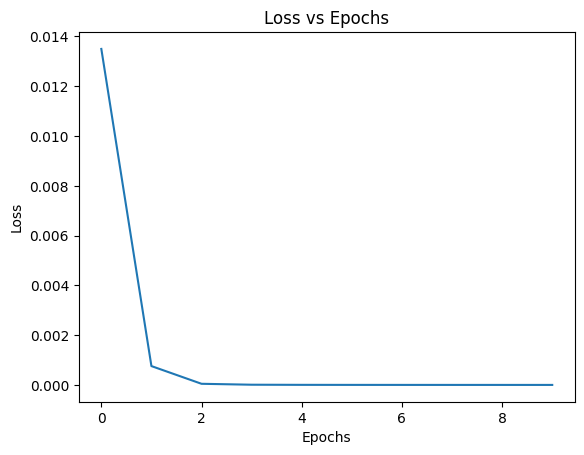

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_arr)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()


In [ ]:
def test_model(model, inputs, targets):
    model.eval()
    y_pred = []
    with torch.no_grad():
        inputs = torch.tensor(inputs, dtype=torch.float32)
        targets = torch.tensor(targets, dtype=torch.float32)
        output = model(inputs)
        rf_pred, dt_pred, svr_pred, lr_pred = get_predictions(inputs)
        all_predictions = torch.tensor(np.vstack([rf_pred, dt_pred, svr_pred, lr_pred]), dtype=torch.float32)
        all_predictions = all_predictions.T
        pred = torch.sum(all_predictions*output, dim=1)
        y_pred.append(pred.numpy())
        loss = criterion(pred, targets)
        print("Test Loss:", loss.item())
        return loss.item(), y_pred
    
# Test the model
test_loss, y_pred = test_model(model, X_test, y_test)
print("Test Loss:", test_loss)


# write code for R2 score
def r2_score(y_true, y_pred):
    """
    Calculate the R^2 score of a model.
    
    Args:
    y_true (ndarray): An array of shape (n_samples,) representing the true target labels.
    y_pred (ndarray): An array of shape (n_samples,) representing the predicted target labels.
    
    Returns:
    float: The R^2 score of the model.
    """
    # Calculate the mean of the true labels
    y_mean = np.mean(y_true)
    
    # Calculate the total sum of squares
    ss_total = np.sum((y_true - y_mean) ** 2)
    
    # Calculate the residual sum of squares
    ss_res = np.sum((y_true - y_pred) ** 2)
    
    # Calculate the R^2 score
    r2 = 1 - (ss_res / ss_total)
    
    return r2

# r2 = r2_score(y_test, y_pred)
# print("R^2 Score:", r2)

Test Loss: 0.09374447911977768
Test Loss: 0.09374447911977768


In [ ]:
# change y_pred to numpy array
y_pred = np.array(y_pred)
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)


R^2 Score: 0.9017446584736118
